## **Zadanie 2 - Algorytm genetyczny**

Cel zadania polega na implementacji algorytmu genetycznego z mutacją, selekcją ruletkową, krzyżowaniem jednopunktowym oraz sukcesją generacyjną.

Zaimplementowany algorytm ma następnie posłużyć do optymalizacji klasycznego, symetrycznego [problemu komiwojażera](https://pl.wikipedia.org/wiki/Problem_komiwojażera).

**Dane:**
| Miasto | Współrzędne |
|--------|-------------|
| A      | (0, 0)      |
| B      | (1, 3)      |
| C      | (2, 1)      |
| D      | (4, 6)      |
| E      | (5, 2)      |
| F      | (6, 5)      |
| G      | (8, 7)      |
| H      | (9, 4)      |
| I      | (10, 8)     |
| J      | (12, 3)     |

**Kroki do wykonania**
- Implementacja algorytmu genetycznego.
- Zastosowanie algorytmu do rozwiązania problemu komiwojażera. Eksperymentalne dobranie zestawu parametrów, dla którego algorytm daje dobry wynik.
- Zbadanie, w jaki sposób następujące zmiany wpłyną na rezultaty osiągane przez algorytm:
  - Zwiększenie prawdopodobieństwa mutacji.
  - Zmiana sposobu selekcji na turniejową.

**Uwagi**
- Ze względu na losowy charakter algorytmu, konieczne jest porównanie uzyskiwanych rezultatów jego działania dla wielu uruchomień i uśrednienie wyników.
- Funkcję przystosowania możemy zdefiniować jako odwrotność łącznej długości trasy dla danej permutacji miast odwiedzanych przez komiwojażera.
- Interesującym, choć nieobowiązkowym dodatkiem byłoby zastosowanie do kodowania osobników kodu Graya. Szczegóły omówione są w podrozdziale 4.2 książki Pawła Wawrzyńskiego Podstawy sztucznej inteligencji (dostępna m.in. online).

In [511]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Implementacja algorytmu genetycznego

In [103]:
GENES = [0, 1]
POPULATION_SIZE = 100
MUTATION_PROBABILITY = 0.01
CROSSOVER_PROBABILITY = 0.7
MAX_GENERATIONS = 100

**Osobonik** reprezentuje punkt w przeszukiwanej przestrzeni. W przypadku problemu komiwojażera jest to permutacja miast.

In [650]:
class Individual:
    def __init__(self, genes):
        self.genes = genes

    def __str__(self):
        return f'{self.genes}'

    @classmethod
    def objective_function(self, ind):
        # example fitness function: sum of all genes
        return -np.sum(ind.genes)

    @classmethod
    def create_genome(self, n, genes=GENES):
        # generate random genome of length n and bit values 0 or 1
        return np.random.choice(genes, n)

In [651]:
Individual.create_genome(10)

array([1, 1, 0, 1, 1, 0, 1, 0, 0, 0])

In [652]:
ind = Individual(Individual.create_genome(10))
print(ind)

[1 1 1 1 0 0 0 1 0 0]


**Populacja** to zbiór osobników przetwarzanych w każdej iteracji algorytmu.

In [654]:
class Population:
    def __init__(self, individuals):
        self.individuals = individuals

    def __str__(self):
        for i, ind in enumerate(self.individuals):
            print(f'Individual {i + 1}: {ind}')
        return ''

    def get_population(self):
        return self.individuals

    def get_individual(self, i):
        return self.individuals[i]

    def get_fitness_values(self, objective_function):
        return [objective_function(ind) for ind in self.individuals]

    def get_best_individual(self, fitness_values):
        return self.individuals[np.argmin(fitness_values)], np.min(fitness_values)

In [655]:
individuals = [Individual(Individual.create_genome(10)) for _ in range(10)]
population = Population(individuals)
print(population)

Individual 1: [0 0 0 0 1 0 0 1 1 1]
Individual 2: [1 1 1 0 1 1 1 1 0 1]
Individual 3: [0 0 1 1 0 1 1 1 1 1]
Individual 4: [1 1 0 0 0 0 1 1 0 1]
Individual 5: [0 1 0 1 1 1 0 0 1 0]
Individual 6: [0 0 1 1 0 0 0 1 1 1]
Individual 7: [0 1 1 0 1 1 1 1 0 0]
Individual 8: [0 0 1 0 0 0 1 0 0 1]
Individual 9: [1 1 0 0 0 1 0 0 0 1]
Individual 10: [0 1 0 1 0 1 0 1 1 1]



In [657]:
class GeneticAlgorithm:
    def __init__(self, objective_function, initial_population, population_size, mutation_prob, crossover_prob, max_generations):
        self.objective_function = objective_function
        self.population = initial_population
        self.population_size = population_size
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations

    def run(self):
        t = 0
        o = self.population.get_fitness_values(self.objective_function)
        x_best, o_best = self.population.get_best_individual(o)

        while t < self.max_generations:
            print(f'Generation {t}: best individual {x_best} with fitness {o_best}')
            R = self.roulette_wheel_selection(self.population.get_population(), o)
            M = self.crossover_and_mutation(R)
            o = M.get_fitness_values(self.objective_function)
            print(M.get_population()[0].genes)
            x_best_new, o_best_new = M.get_best_individual(o)

            if o_best_new <= o_best:
                x_best, o_best = x_best_new, o_best_new

            self.population = copy.copy(M)
            t += 1

        print(f'Generation {t}: best individual {x_best} with fitness {o_best}')


    def roulette_wheel_selection(self, population_t, fitness_values):
        probabilities = fitness_values / np.sum(fitness_values)
        return Population(np.random.choice(population_t, size=self.population_size, p=probabilities))

    def crossover_and_mutation(self, R):
        new_population = []

        current_population = R.get_population()
        for i in range(0, len(current_population), 2):
            parent1, parent2 = current_population[i], current_population[i + 1]
            child1, child2 = None, None

            if np.random.rand() < self.crossover_prob:
                crossover_point = np.random.randint(0, len(parent1.genes))
                child1 = np.concatenate((parent1.genes[:crossover_point], parent2.genes[crossover_point:]))
                child2 = np.concatenate((parent2.genes[:crossover_point], parent1.genes[crossover_point:]))

            if child1 is not None and child2 is not None:
                new_population.append(Individual(child1))
                new_population.append(Individual(child2))
            else:
                new_population.append(parent1)
                new_population.append(parent2)


        for i in range(len(new_population)):
            for j in range(len(new_population[i].genes)):
                if np.random.rand() < self.mutation_prob:
                    new_population[i].genes[j] = 1 - new_population[i].genes[j]

        return Population(new_population)


In [660]:
population = Population([Individual(Individual.create_genome(20)) for _ in range(POPULATION_SIZE)])

In [661]:
ga = GeneticAlgorithm(Individual.objective_function, population, len(population.get_population()), 0.01, 0.8, 1000)

ga.run()

Generation 0: best individual [1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1] with fitness -15
[1 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0]
Generation 1: best individual [1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1] with fitness -15
[0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1]
Generation 2: best individual [1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1] with fitness -16
[0 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1]
Generation 3: best individual [1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1] with fitness -17
[0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0]
Generation 4: best individual [1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1] with fitness -17
[1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1]
Generation 5: best individual [1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1] with fitness -17
[0 1 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0]
Generation 6: best individual [1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1] with fitness -17
[1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1]
Generation 7: best individual [1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1] with fitnes

### Zastosowanie algorytmu do rozwiązania problemu komiwojażera

In [644]:
city_data = {
    'Miasto': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'x': [0, 1, 2, 4, 5, 6, 8, 9, 10, 12],
    'y': [0, 3, 1, 6, 2, 5, 7, 4, 8, 3]
}

In [645]:
df = pd.DataFrame(city_data)
df.head()

,Miasto,x,y
0,A,0,0
1,B,1,3
2,C,2,1
3,D,4,6
4,E,5,2


In [662]:
def visualize_map(df):
    plt.figure(figsize=(6,6))
    plt.scatter(df['x'], df['y'], s=200)

    for _, row in df.iterrows():
        plt.text(row['x'], row['y'], row['Miasto'], fontsize=10, ha='center', va='center')

    plt.title('Wizualizacja miast')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

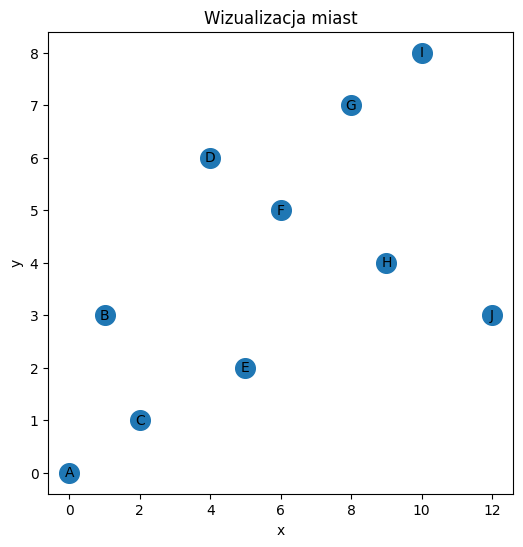

In [663]:
visualize_map(df)

In [648]:
cities_list = df['Miasto'].values
cities_list

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype=object)

In [705]:
class IndividualCity:
    def __init__(self, cities):
        self.cities = cities
        self.fitness = self.total_distance(cities, df)

    def __str__(self):
        return f'{self.cities}'

    @classmethod
    def create_genome(self, cities):
        return np.random.permutation(cities)

    @classmethod
    def distance(self, city1, city2, df):
        x1, y1 = df[df['Miasto'] == city1].values[0][1:]
        x2, y2 = df[df['Miasto'] == city2].values[0][1:]

        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    @classmethod
    def total_distance(self, cities, df):
        return sum([self.distance(cities[i], cities[i + 1], df) for i in range(len(cities) - 1)]) + self.distance(cities[-1], cities[0], df)

    @classmethod
    def objective_function(self, ind):
        return 1 / ind.fitness

In [706]:
ind = IndividualCity(IndividualCity.create_genome(cities_list))

In [707]:
ind.cities, ind.fitness

(array(['J', 'C', 'E', 'H', 'I', 'B', 'G', 'A', 'F', 'D'], dtype=object),
 69.53391336871536)

In [709]:
class PopulationCity:
    def __init__(self, individuals):
        self.individuals = individuals

    def __str__(self):
        for i, ind in enumerate(self.individuals):
            print(f'Individual {i + 1}: {ind}, total distance: {round(ind.fitness, 2)}')
        return ''

    def get_population(self):
        return self.individuals

    def get_individual(self, i):
        return self.individuals[i]

    def get_fitness_values(self, objective_function):
        return [objective_function(ind) for ind in self.individuals]

    def get_best_individual(self, fitness_values):
        return self.individuals[np.argmax(fitness_values)], np.max(fitness_values)

In [710]:
individuals = [IndividualCity(IndividualCity.create_genome(cities_list)) for _ in range(20)]
population = PopulationCity(individuals)
print(population)

Individual 1: ['B' 'I' 'C' 'J' 'G' 'H' 'D' 'A' 'E' 'F'], total distance: 66.47
Individual 2: ['H' 'E' 'G' 'A' 'I' 'J' 'B' 'D' 'F' 'C'], total distance: 69.88
Individual 3: ['B' 'E' 'I' 'H' 'D' 'A' 'J' 'C' 'F' 'G'], total distance: 67.77
Individual 4: ['F' 'G' 'A' 'J' 'B' 'I' 'H' 'E' 'C' 'D'], total distance: 66.5
Individual 5: ['C' 'I' 'G' 'J' 'A' 'D' 'B' 'H' 'E' 'F'], total distance: 63.7
Individual 6: ['A' 'G' 'H' 'B' 'I' 'J' 'D' 'C' 'E' 'F'], total distance: 65.6
Individual 7: ['E' 'H' 'B' 'D' 'G' 'I' 'F' 'A' 'J' 'C'], total distance: 61.68
Individual 8: ['G' 'A' 'F' 'E' 'H' 'I' 'C' 'D' 'J' 'B'], total distance: 73.82
Individual 9: ['A' 'J' 'I' 'D' 'F' 'H' 'E' 'B' 'C' 'G'], total distance: 59.42
Individual 10: ['H' 'E' 'I' 'C' 'F' 'G' 'J' 'B' 'A' 'D'], total distance: 63.81
Individual 11: ['A' 'G' 'B' 'J' 'C' 'I' 'F' 'E' 'D' 'H'], total distance: 78.04
Individual 12: ['F' 'E' 'A' 'G' 'I' 'H' 'J' 'B' 'C' 'D'], total distance: 49.56
Individual 13: ['C' 'G' 'B' 'J' 'D' 'E' 'F' 'A' 'H' 

Funkcja przystosowania dla problemu komiwojażera to odwrotność łącznej długości trasy dla danej permutacji miast odwiedzanych przez komiwojażera.

In [716]:
class GeneticAlgorithm:
    def __init__(self, objective_function, initial_population, population_size, mutation_prob, crossover_prob, max_generations):
        self.objective_function = objective_function
        self.population = initial_population
        self.population_size = population_size
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations

    def run(self):
        t = 0
        o = self.population.get_fitness_values(self.objective_function)
        x_best, o_best = self.population.get_best_individual(o)

        while t < self.max_generations:
            print(f'Generation {t}: best individual {x_best} with fitness {o_best}')
            R = self.roulette_wheel_selection(self.population.get_population(), o)
            M = self.crossover_and_mutation(R)
            o = M.get_fitness_values(self.objective_function)
            x_best_new, o_best_new = M.get_best_individual(o)

            if o_best_new > o_best:
                x_best, o_best = x_best_new, o_best_new

            self.population = copy.copy(M)
            t += 1

        print(f'Generation {t}: best individual {x_best} with fitness {o_best}')


    def roulette_wheel_selection(self, population_t, fitness_values):
        probabilities = fitness_values / np.sum(fitness_values)
        return PopulationCity(np.random.choice(population_t, size=self.population_size, p=probabilities))

    def crossover_and_mutation(self, R):
        new_population = []

        current_population = R.get_population()
        for i in range(0, len(current_population), 2):
            parent1, parent2 = current_population[i], current_population[i + 1]
            child1, child2 = None, None

            if np.random.rand() < self.crossover_prob:
                crossover_point = np.random.randint(0, len(parent1.cities))
                child1 = parent1.cities[:crossover_point]
                child2 = parent2.cities[:crossover_point]

                for city in parent2.cities:
                    if city not in child1:
                        child1 = np.append(child1, city)

                for city in parent1.cities:
                    if city not in child2:
                        child2 = np.append(child2, city)

            if child1 is not None and child2 is not None:
                new_population.append(IndividualCity(child1))
                new_population.append(IndividualCity(child2))
            else:
                new_population.append(parent1)
                new_population.append(parent2)


        for i in range(len(new_population)):
            for j in range(len(new_population[i].cities)):
                if np.random.rand() < self.mutation_prob:
                    idx1, idx2 = np.random.choice(len(new_population[i].cities), 2)
                    new_population[i].cities[idx1], new_population[i].cities[idx2] = new_population[i].cities[idx2], new_population[i].cities[idx1]

        return PopulationCity(new_population)


In [719]:
ga_city = GeneticAlgorithm(IndividualCity.objective_function, population, len(population.get_population()), 0.01, 0.8, 200)

In [720]:
ga_city.run()

Generation 0: best individual ['F' 'E' 'A' 'G' 'I' 'H' 'J' 'B' 'C' 'D'] with fitness 0.020179052646667577
Generation 1: best individual ['H' 'C' 'A' 'B' 'J' 'F' 'E' 'D' 'I' 'G'] with fitness 0.02026467353398713
Generation 2: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'F' 'D' 'G'] with fitness 0.027102121304016968
Generation 3: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'F' 'D' 'G'] with fitness 0.027102121304016968
Generation 4: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'F' 'D' 'G'] with fitness 0.027102121304016968
Generation 5: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'F' 'D' 'G'] with fitness 0.027102121304016968
Generation 6: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'F' 'D' 'G'] with fitness 0.027102121304016968
Generation 7: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'D' 'F' 'G'] with fitness 0.029018918398995158
Generation 8: best individual ['I' 'H' 'J' 'E' 'C' 'A' 'B' 'D' 'F' 'G'] with fitness 0.029018918398995158
Generation 9: best individual ['I' 'H' 'J' 'E' 

In [721]:
IndividualCity.total_distance(['F', 'E', 'A', 'G', 'I', 'H', 'J', 'B', 'C', 'D'], df)

49.55634030545744

In [722]:
IndividualCity.total_distance(['I', 'H', 'J', 'E', 'C', 'A', 'B', 'D', 'F', 'G'], df)

34.46027816235312

In [723]:
def visualize_map_with_path(path, df):
    plt.figure(figsize=(6,6))
    plt.scatter(df['x'], df['y'], s=200)

    for _, row in df.iterrows():
        plt.text(row['x'], row['y'], row['Miasto'], fontsize=10, ha='center', va='center')

    for i in range(len(path) - 1):
        city1 = path[i]
        city2 = path[i + 1]

        x1, y1 = df[df['Miasto'] == city1].values[0][1:]
        x2, y2 = df[df['Miasto'] == city2].values[0][1:]

        plt.plot([x1, x2], [y1, y2], 'k-')

    plt.plot([df[df['Miasto'] == path[-1]].values[0][1], df[df['Miasto'] == path[0]].values[0][1]], [df[df['Miasto'] == path[-1]].values[0][2], df[df['Miasto'] == path[0]].values[0][2]], 'k-')

    plt.title('Wizualizacja miast')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

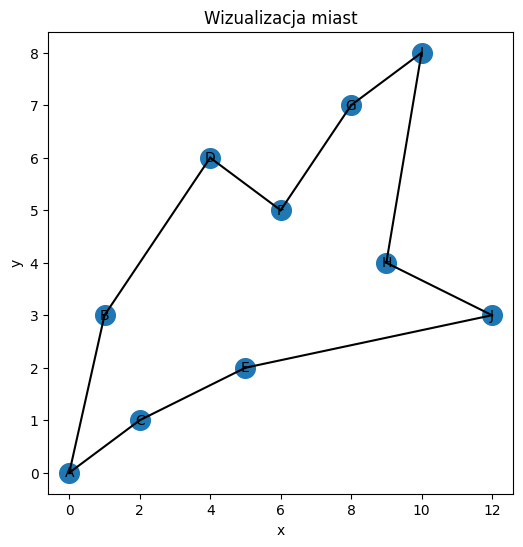

In [726]:
visualize_map_with_path(['I', 'H', 'J', 'E', 'C', 'A', 'B', 'D', 'F', 'G'], df)

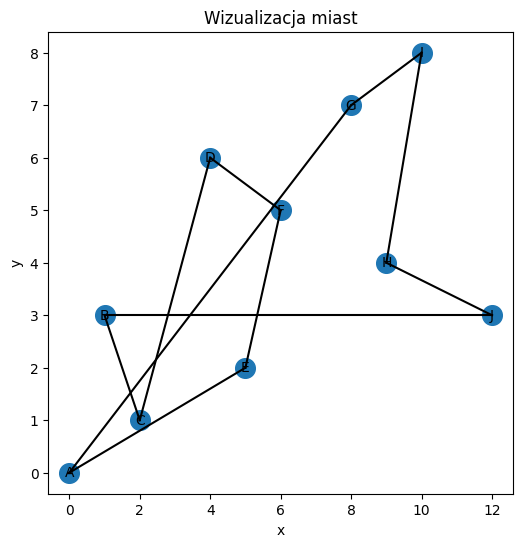

In [727]:
visualize_map_with_path(['F', 'E', 'A', 'G', 'I', 'H', 'J', 'B', 'C', 'D'], df)

### Zbadanie wpływu zmian na rezultaty osiągane przez algorytm

#### Zwiększenie prawdopodobieństwa mutacji

#### Zmiana sposobu selekcji na turniejową